# Fitting

In [29]:
import matplotlib.pyplot as plt
from pyhdx import PeptideMasterTable, read_dynamx, HDXMeasurement
from pyhdx.fitting import fit_rates_half_time_interpolate, fit_rates_weighted_average, fit_gibbs_global
from pathlib import Path
import numpy as np
from dask.distributed import Client

We load the sample SecB dataset, apply the control, and create an ``HDXMeasurement`` object.

In [26]:
fpath = Path() / '..' / '..' / 'tests' / 'test_data' / 'ecSecB_apo.csv'
data = read_dynamx(fpath)
master_table = PeptideMasterTable(data, drop_first=1, ignore_prolines=True)
master_table.set_control(('Full deuteration control', 0.167))
state_data = master_table.get_state('SecB WT apo')
hdxm = HDXMeasurement(state_data, temperature=303.15, pH=8.)

The first step is to obtain initial guesses for the observed rate of D-exchange.
By determining the timepoint at which 0.5 RFU (relative fractional uptake) is reached, and subsequently converting to rate,
a rough estimate of exchange rate per residue can be obtained. Here, RFU values are mapped from peptides to individual
residues by weighted averaging (where the weight is the inverse of peptide length)

In [28]:
fr_half_time = fit_rates_half_time_interpolate(hdxm)
fr_half_time.output

C:\Users\jhsmi\pp\PyHDX\pyhdx\models.py:647: RuntimeWarning: invalid value encountered in true_divide
  return self.Z / np.sum(self.Z, axis=0)[np.newaxis, :]


,rate
r_number,
10,3.267322
11,3.267322
12,2.118046
13,2.118046
14,2.118046
...,...
151,8.196291
152,8.187618
153,8.187618


A more accurate result can be obtained by fitting the per-residue/timepoint RFU values to a biexponential association curve.
This process is more time consuming and can optionally be processed in parallel by Dask.

In [30]:
client = Client()
fr_wt_avg = fit_rates_weighted_average(hdxm, client=client)

C:\Users\jhsmi\pp\PyHDX\pyhdx\models.py:647: RuntimeWarning: invalid value encountered in true_divide
  return self.Z / np.sum(self.Z, axis=0)[np.newaxis, :]


The return value is a ``KineticsFitResult`` object. This object has a list of models, intervals in withing the protein 
sequence to which these models apply, and their corresponding ``symfit`` fit result with parameter values. The effective 
exchange rate can be extracted, as well as other fit parameters, from this object:

In [8]:
fr_wt_avg.output

C:\Users\jhsmi\pp\PyHDX\pyhdx\fit_models.py:224: RuntimeWarning: overflow encountered in exp
  t = np.exp(t_log)


,rate,k1,k2,r
r_number,,,,
10,0.000152,6.575096,0.000144,0.034594
11,0.000152,6.575096,0.000144,0.034594
12,0.000145,6.360308,0.000139,0.028303
13,0.000145,6.360308,0.000139,0.028303
14,0.000145,6.360308,0.000139,0.028303
...,...,...,...,...
151,0.000157,167.066539,0.000139,0.077195
152,0.000157,87.551071,0.000139,0.076878
153,0.000157,87.551071,0.000139,0.076878


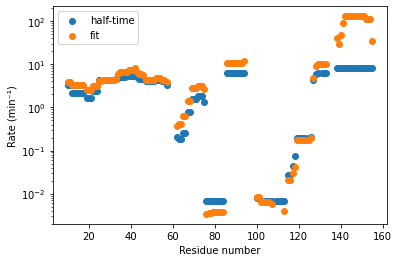

In [34]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.scatter(fr_half_time.output.index, fr_half_time.output['rate'], label='half-time')
ax.scatter(fr_wt_avg.output.index, fr_wt_avg.output['rate'], label='fit')

ax.set_xlabel('Residue number')
ax.set_ylabel('Rate (min⁻¹)')
ax.legend()


In [16]:
fr_half_time.output.index
fr_half_time.output['rate']

r_number
10     0.006931
11     0.006931
12     0.006931
13     0.006931
14     0.006931
         ...   
151    0.006931
152    0.006931
153    0.006931
154    0.006931
155    0.006931
Name: rate, Length: 146, dtype: float64

We can now use the guessed rates to obtain guesses for the Gibbs free energy. Units of Gibbs free energy are J/mol.

In [37]:
gibbs_guess = hdxm.guess_deltaG(fr_wt_avg.output['rate'])
gibbs_guess

C:\Users\jhsmi\Miniconda3\envs\py38_pyhdx_pn011\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


r_number
10     19747.939087
11     19283.438679
12     20646.641138
13     16871.792590
14     18962.895160
           ...     
151     9109.773437
152    10090.269807
153    12514.149431
154    12793.578998
155     1359.395360
Length: 146, dtype: float64

To perform the global fit (all peptides and timepoints) use ``fit_gibbs_global``. The number of epochs is set to 1000
here for demonstration but for actually fitting the values should be ~100000.

In [39]:
gibbs_result = fit_gibbs_global(hdxm, gibbs_guess, epochs=1000)
gibbs_output = gibbs_result.output
gibbs_output

,sequence,_deltaG,deltaG,pfact,covariance
r_number,,,,,
10,T,19744.187025,19744.187025,2523.367012,1.402503e+03
11,F,19321.203772,19321.203772,2133.532120,1.396647e+03
12,Q,20644.909999,20644.909999,3607.261193,7.731552e+02
13,I,16925.579275,16925.579275,824.757302,7.684344e+02
14,Q,18988.928838,18988.928838,1870.024322,7.705967e+02
...,...,...,...,...,...
151,E,9137.345851,9137.345851,37.531080,3.140214e+06
152,H,10090.269810,10090.269810,54.775029,9.471769e+05
153,Q,12514.149434,12514.149434,143.292702,9.369857e+05


Along with ΔG the fit result returns covariances of ΔG and protection factors.

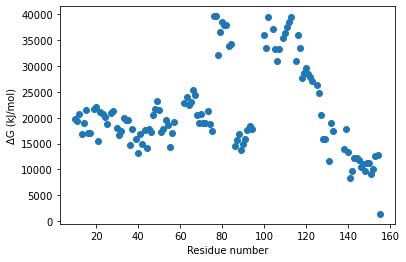

In [40]:
fig, ax = plt.subplots()
#ax.set_yscale('log')
ax.scatter(gibbs_output.index, gibbs_output['deltaG']*1e-3)
ax.set_xlabel('Residue number')
ax.set_ylabel('ΔG (kJ/mol)')
None


